# LSTM ile Hisse Senedi(Tesla) Fiyatı Tahmini

# 1) Business Problem

- **Date:** İlgili işlem gününün tarihini temsil etmektedir.
-**Open:**İlgili işlem gününe ait hisse başlangıç fiyatını temsil etmektedir.
- **High:** İlgili işlem gününe ait en yüksek fiyatı temsil etmektedir.
- **Low:** İlgili işlem gününe ait en düşük fiyatı temsil etmektedir.
-**Close:** İlgili işlem gününde hisse senedinin kapanış fiyatını temsil etmektedir.
-**Adj Close:** İlgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatını temsil etmektedir.
-**Volume:** İlgili işlem gününe ait işlem hacmi bilgisini temsil etmektedir.

# 2)Data Understanding

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
df = pd.read_csv("/content/Tesla.csv ")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [11]:
def check_df(dataframe, head=5):
    print("################# Shape ###############")
    print(dataframe.shape)
    print("################# Types ###############")
    print(dataframe.dtypes)
    print("################# Head ###############")
    print(dataframe.head(head))
    print("################# Tail ###############")
    print(dataframe.tail(head))
    print("################# NA ###############")
    print(dataframe.isnull().sum())
    print("################# Quantiles ###############")

    # Selecting only numeric columns for quantile calculation
    numeric_cols = dataframe.select_dtypes(include='number')
    if not numeric_cols.empty:
        print(numeric_cols.quantile([0, 0.05, 0.50, 0.95, 0.90, 1]).T)
    else:
        print("No numeric columns available for quantile calculation.")

In [12]:
check_df(df)

################# Shape ###############
(1692, 7)
################# Types ###############
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object
################# Head ###############
        Date       Open   High        Low      Close    Volume  Adj Close
0  6/29/2010  19.000000  25.00  17.540001  23.889999  18766300  23.889999
1  6/30/2010  25.790001  30.42  23.299999  23.830000  17187100  23.830000
2   7/1/2010  25.000000  25.92  20.270000  21.959999   8218800  21.959999
3   7/2/2010  23.000000  23.10  18.709999  19.200001   5139800  19.200001
4   7/6/2010  20.000000  20.00  15.830000  16.110001   6866900  16.110001
################# Tail ###############
           Date        Open        High         Low       Close   Volume   Adj Close
1687  3/13/2017  244.820007  246.850006  242.779999  246.169998  3010700  246.169998
1688  3/14/2017  246.110001  258.119995  246.020004  258.

In [13]:
df["Date"] = pd.to_datetime(df["Date"])

In [14]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [15]:
tesla_df = df[["Date", "Close"]]

In [16]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [17]:
print("Minimum Tarih:", tesla_df["Date"].min())
print("Maksimum Tarih:", tesla_df["Date"].max())

Minimum Tarih: 2010-06-29 00:00:00
Maksimum Tarih: 2017-03-17 00:00:00


In [18]:
tesla_df.index = tesla_df["Date"]

In [19]:
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2017-03-13,2017-03-13,246.169998
2017-03-14,2017-03-14,258.000000
2017-03-15,2017-03-15,255.729996


In [23]:
tesla_df.drop("Date", axis=1, inplace=True)

In [24]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2017-03-13,246.169998
2017-03-14,258.000000
2017-03-15,255.729996


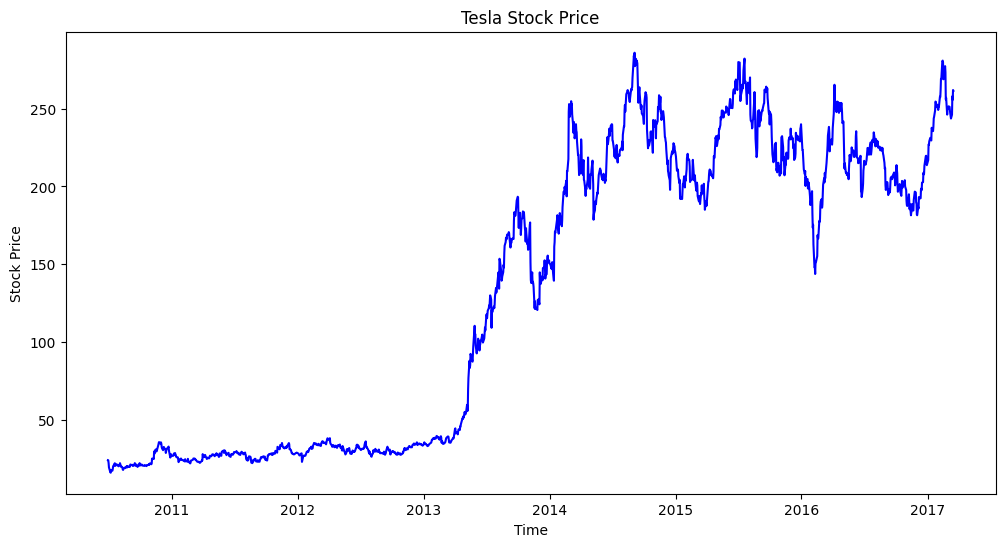

In [28]:
plt.figure(figsize=(12,6))
plt.plot(tesla_df["Close"], color="blue");
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("Tesla Stock Price")
plt.show()


In [29]:
tesla_df = tesla_df.values

In [30]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [31]:
tesla_df = tesla_df.astype("float32")

In [32]:
# train-test ayrımı

def split_data(dataframe, test_size):
  pos = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:pos]
  test = dataframe[pos:]
  return train, test, pos

In [33]:
train, test, pos = split_data(tesla_df, 0.20)

In [34]:
print(train.shape, test.shape)

(1354, 1) (338, 1)


In [35]:
scaler_train = MinMaxScaler(feature_range=(0, 1))

In [36]:
train = scaler_train.fit_transform(train)

In [37]:
scaler_test = MinMaxScaler(feature_range= (0, 1))

In [38]:
test = scaler_test.fit_transform(test)

In [40]:
train[0:5]

array([[0.02993634],
       [0.02971432],
       [0.02279454],
       [0.01258141],
       [0.00114713]], dtype=float32)

In [41]:
test[0:5]

array([[0.50447893],
       [0.46260297],
       [0.5144564 ],
       [0.5121987 ],
       [0.56368804]], dtype=float32)

In [43]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [44]:
lookback = 20

In [45]:
x_train, y_train = create_features(train, lookback)

x_test, y_test = create_features(test, lookback)

In [47]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1334, 20) (1334,) (318, 20) (318,)


In [48]:
x_train[0:5]

array([[0.02993634, 0.02971432, 0.02279454, 0.01258141, 0.00114713,
        0.        , 0.00614268, 0.00592066, 0.00462551, 0.00865897,
        0.01494967, 0.01513469, 0.01791   , 0.02260953, 0.01665186,
        0.01635583, 0.01924215, 0.02031527, 0.01905713, 0.01757696],
       [0.02971432, 0.02279454, 0.01258141, 0.00114713, 0.        ,
        0.00614268, 0.00592066, 0.00462551, 0.00865897, 0.01494967,
        0.01513469, 0.01791   , 0.02260953, 0.01665186, 0.01635583,
        0.01924215, 0.02031527, 0.01905713, 0.01757696, 0.01820603],
       [0.02279454, 0.01258141, 0.00114713, 0.        , 0.00614268,
        0.00592066, 0.00462551, 0.00865897, 0.01494967, 0.01513469,
        0.01791   , 0.02260953, 0.01665186, 0.01635583, 0.01924215,
        0.02031527, 0.01905713, 0.01757696, 0.01820603, 0.01683688],
       [0.01258141, 0.00114713, 0.        , 0.00614268, 0.00592066,
        0.00462551, 0.00865897, 0.01494967, 0.01513469, 0.01791   ,
        0.02260953, 0.01665186, 0.01635583, 0

In [49]:
y_train[0:5]

array([0.01820603, 0.01683688, 0.01531971, 0.01894612, 0.02275755],
      dtype=float32)

In [50]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1334, 1, 20) (1334, 1) (318, 1, 20) (318, 1)


# 4) Modeling

In [51]:
model = Sequential()
model.add(LSTM(units=50,
               activation="relu",
               input_shape=(x_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [55]:
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
             ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min",
                             save_best_only=True, save_weights_only=False, verbose=1)]

In [56]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(x_test, y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/100
65/67 [============================>.] - ETA: 0s - loss: 0.0107
Epoch 1: val_loss improved from inf to 0.01418, saving model to mymodel.h5
67/67 [==============================] - 5s 11ms/step - loss: 0.0107 - val_loss: 0.0142
Epoch 2/100
57/67 [========================>.....] - ETA: 0s - loss: 0.0063
Epoch 2: val_loss did not improve from 0.01418
67/67 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0143
Epoch 3/100
55/67 [=======================>......] - ETA: 0s - loss: 0.0051
Epoch 3: val_loss improved from 0.01418 to 0.01409, saving model to mymodel.h5
67/67 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0141
Epoch 4/100
66/67 [============================>.] - ETA: 0s - loss: 0.0072
Epoch 4: val_loss improved from 0.01409 to 0.01348, saving model to mymodel.h5
67/67 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0135
Epoch 5/100
63/67 [===========================>..] - ETA: 0s - loss

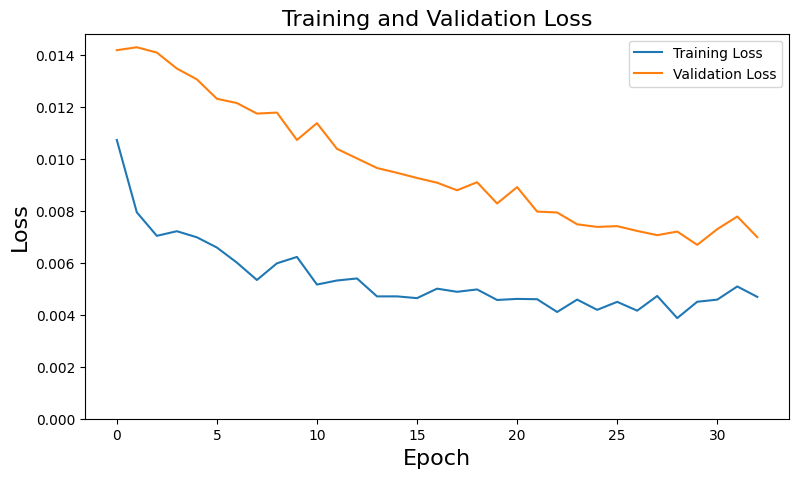

In [58]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

# 5) Evaluation

In [59]:
loss = model.evaluate(x_test, y_test, batch_size=20)
print("\nTest loss: %.1f%%" % (100.0 * loss))


16/16 [==============================] - 0s 3ms/step - loss: 0.0070

Test loss: 0.7%


In [60]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

10/10 [==============================] - 0s 4ms/step


In [61]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [62]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [63]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [64]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [65]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 9.245073318481445
Test RMSE: 11.477987289428711


In [72]:
train_prediction_df = tesla_df[lookback:pos]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

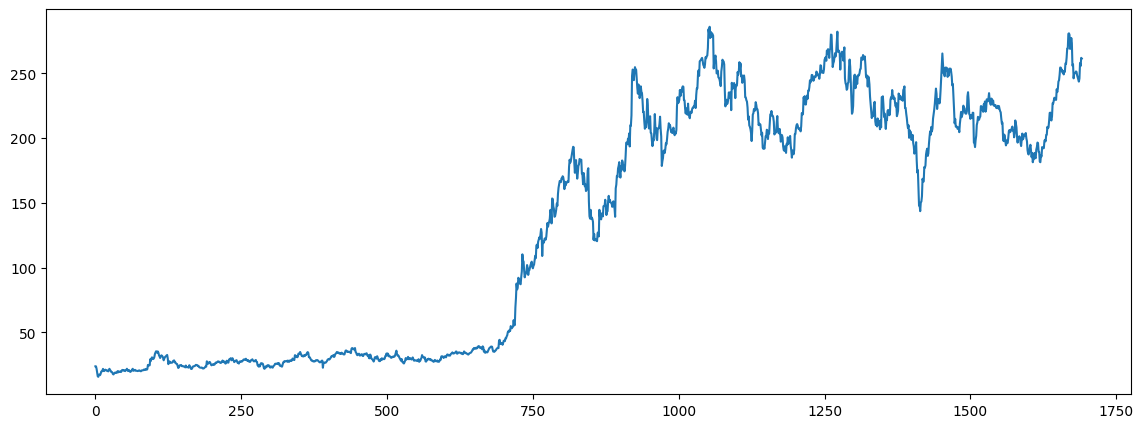

In [73]:
plt.figure(figsize=(14,5))
plt.plot(tesla_df, label="Real Values")
plt.plot(train_prediction_df["Predicted"], color = "blue", label="Train Predicted")
plt.plot(test_prediction_df["Predicted"], color = "reed", label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()